[View in Colaboratory](https://colab.research.google.com/github/zabiullakhangithub/Image_Classification_Project_2/blob/master/Image_Classification_Project_2.ipynb)

**Image Classification Project** In this project, you'll classify images from the CIFAR-10 dataset



#Step:1 Downloading data from source




In [0]:
from urllib.request import urlretrieve
from os.path import isfile,isdir
from tqdm import tqdm
import tarfile

    
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import random

In [0]:
cifar10_dataset_folder_path = 'cifar-10-batches-py'

In [0]:
class DLProgress(tqdm):
  last_block = 0
  
  def hook(self,block_num=1,block_size=1,total_size=None):
    self.total = total_size
    self.update((block_num-self.last_block)*block_size)
    self.last_block=block_num

In [17]:
if not isfile('cifar-10-python.tar.gz'):
  with DLProgress(unit='B',unit_scale=True,miniters=1,desc='CIFAR-10 Dataset') as pbar:
    urlretrieve('https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz','cifar-10-python.tar.gz',pbar.hook)
                
if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

CIFAR-10 Dataset: 171MB [00:04, 38.9MB/s]                           


# Step:2 Data Visualization

In [0]:
#function to unpickle images & label_names
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [0]:
#get label names from batches.meta file
label_names = unpickle("{}/batches.meta".format(cifar10_dataset_folder_path))
label_name_array=label_names[b'label_names']

In [0]:

#get images and label index from batch files#get ima 
batch_num = 5 ## values 1 to 5 only
data_label = unpickle("{}/data_batch_{}".format(cifar10_dataset_folder_path,batch_num))

data = data_label[b'data']
imgs=np.asanyarray(data).astype("uint8")

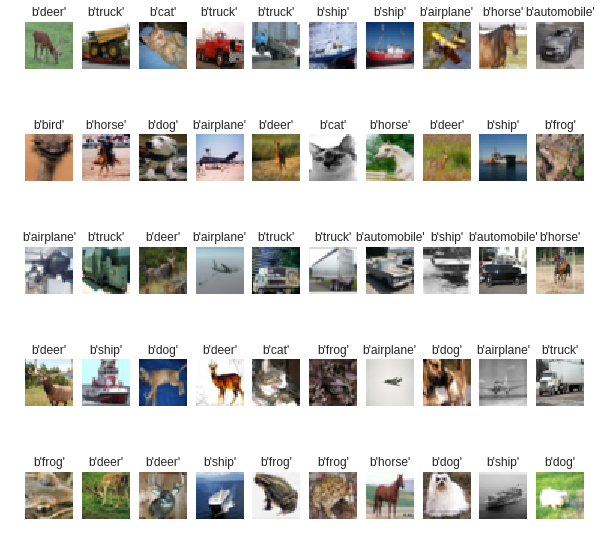

In [21]:
columns = 10
rows = 5
fig=plt.figure(figsize=(10, 10))

for i in range(1, columns*rows +1):
    num = random.randint(0,10000)
    one_img=imgs[num,:]
    img=one_img.reshape(3,32,32).transpose([1, 2, 0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
    fig.gca().grid(False)
    plt.title(label_name_array[int(data_label[b'labels'][num])])

# Step:3 Data Preprocessing & Saving

In [0]:
## Function to normalize image data## Funct 
## This is to convert RGB image to gray scale image of range 0 to 1
def normalize(x):
  return x/255  ## min value is 0 & max value is 255 for RGB

In [0]:
## Function for one-hot encoding 
def one_hot_encoding(x):
  return np.asarray(pd.get_dummies(x))

In [0]:
## Function to load batch from data set
def load_cifar10_batch(cifar10_dataset_folder_path,batch_num):
  data_label = unpickle("{}/data_batch_{}".format(cifar10_dataset_folder_path,batch_num))
  #print(data_label)
  features = data_label[b'data'].reshape(len(data_label[b'data']),3,32,32).transpose(0,2,3,1)
  labels = data_label[b'labels']
  return features,labels

## Function to load test data from data set
def load_cifar10_test(cifar10_dataset_folder_path):
  data_label = unpickle("{}/test_batch".format(cifar10_dataset_folder_path))
  features = data_label[b'data'].reshape(len(data_label[b'data']),3,32,32).transpose(0,2,3,1)
  labels = data_label[b'labels']
  return features,labels

In [0]:
## Function to normalize features and perform one_hot_encoding on labels
def _preprocess_and_save(normalize,one_hot_encoding,features,labels,filename):
  features = normalize(features)
  labels = one_hot_encoding(labels)
  pickle.dump((features,labels),open(filename,'wb'))

In [0]:
## Function to preprocess,split and save Traing, Validation & Test Data
def preprocess_and_save(cifar10_dataset_folder_path,normalize,one_hot_encoding):
  
  num_batches = 5
  valid_features = []
  valid_labels = []
  
  for i in range (1,num_batches+1):
    
    # Load Data from batches
    features,labels = load_cifar10_batch(cifar10_dataset_folder_path,i)
    valid_count = int(len(features)*0.1)
    
    #print(features[:-valid_count])
    #To Save Traing Data
    _preprocess_and_save(normalize,one_hot_encoding,features[:-valid_count],labels[:-valid_count],"preprocess_batch_{}.p".format(i)) 
    
    # Validation Data from batch
    valid_features.extend(features[-valid_count:])
    valid_labels.extend(labels[-valid_count:])
  
  # To Save Validation Data
  _preprocess_and_save(normalize,one_hot_encoding,np.asarray(valid_features),np.asarray(valid_labels),"preprocess_validation.p".format(i))
  
  
  # To Save Test Data 
  
  features_test,labels_test = load_cifar10_test(cifar10_dataset_folder_path)
  _preprocess_and_save(normalize,one_hot_encoding,features_test,labels_test,"preprocess_test.p".format(i))

In [0]:
## Preprocess and save Train, Validation & Test Data
preprocess_and_save(cifar10_dataset_folder_path,normalize,one_hot_encoding)

In [29]:

!ls

cifar-10-batches-py	preprocess_batch_2.p  preprocess_test.p
cifar-10-python.tar.gz	preprocess_batch_3.p  preprocess_validation.p
datalab			preprocess_batch_4.p
preprocess_batch_1.p	preprocess_batch_5.p


# Step:4 Implementing Input Methods

In [0]:
## Function to return batch of Image Input
def neural_net_image_input(image_shape):
  return tf.placeholder(tf.float32,shape=(None,)+image_shape,name='x')

In [0]:
## Function to return batch of Label Input
def neural_net_label_input(n_classes):
  return tf.placeholder(tf.float32,shape=(None,n_classes),name='y')

In [0]:
## Function to return keep probability for drop outs## Funct 
def neural_net_keep_prob_input():
  return tf.placeholder(tf.float32,name='keep_prob')

# Step:5 Implementing Convolution and Max Pooling Layer

In [0]:
## This is to build Convolution and Max Pooling Layer
#x_tensor: input
#conv_num_outputs: Number of output from convolution layer
#conv_ksize : convolutional layer kernal size
#conv_strides : convolutionallayer Sride
#pool_ksize: max-pooling kernal size
#pool_strides: max-pooling srides 
#


def conv2d_maxpool(x_tensor,conv_num_outputs,conv_ksize,conv_strides,pool_ksize,pool_strides):
  
  ## To Caluculate weights and bias
  weights = tf.Variable(tf.truncated_normal([*conv_ksize,x_tensor.shape.as_list()[3],conv_num_outputs],stddev=5e-2))
  bias = tf.Variable(tf.zeros(conv_num_outputs))
  
  ## Convolution layer
  
  conv_layer = tf.nn.conv2d(x_tensor,weights,strides=[1,*conv_strides,1],padding='SAME')
  
  ## Add bias
  
  conv_layer = tf.nn.bias_add(conv_layer,bias)
  
  
  ## Add activation function
  
  conv_layer = tf.nn.relu(conv_layer)
  
  
  ## Add max-pooling 
  
  conv_layer = tf.nn.max_pool(conv_layer,ksize=[1,*pool_ksize,1],strides=[1,*pool_strides,1],padding='SAME')
  
  return conv_layer

# Step:6 Implementing Flatten Layer

In [0]:
def flatten(x_tensor):
  return tf.contrib.layers.flatten(x_tensor) ## Using tensorflow flatten function

# Step:7 Implementing Fully Connected Layer


In [0]:
def fully_conn(x_tensor,num_outputs):
  return tf.layers.dense(x_tensor,num_outputs)

# Step:8 Implementing Output Layer


In [0]:
def output(x_tensor,num_outputs):
  return tf.layers.dense(x_tensor,num_outputs)

# Step:9 Implementing Convolution Network


In [0]:
def conv_net(x,keep_prob):
  
  # Apply 3 convolutional layers
  
  
  ## Convolution Layer-1
  x = conv2d_maxpool(x,64,(5,5),(1,1),(3,3),(2,2))
  x = tf.layers.dropout(x,rate=keep_prob)
  
  ## Convolution Layer-2
  x = conv2d_maxpool(x,64,(5,5),(1,1),(3,3),(2,2))
  x = tf.layers.dropout(x,rate=keep_prob)
  
  ## Convolution Layer-3
  #x = conv2d_maxpool(x,64,(5,5),(1,1),(3,3),(2,2))
  #x = tf.layers.dropout(x,rate=keep_prob)
  
  
  # Apply Flatten Layer
  x = flatten(x)
  
  
  
  # Apply 3 Fully Connected Layers
  
  #x = fully_conn(x,768)
  x = fully_conn(x,384)
  x = fully_conn(x,192)
  #x = fully_conn(x,86)
  #x = fully_conn(x,43)
  
  
  # Apply output Layer
  
  x = output(x,10)
  
  return x

# Step 10: Implement Tensorflow Neural Network


In [0]:
tf.reset_default_graph()

In [0]:
#Inputs
x = neural_net_image_input((32,32,3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

In [40]:
logits = conv_net(x,keep_prob)

TypeError: ignored